## Transfer Learning: AlexNet Model

**Dataset used: Ants & Bees Dataset** (freely available on Kaggle)

Implementation by: Om Prabhu (19D170018)

We try to distinguish and and bees with the help of a CNN model using the AlexNet architecture.

In [21]:
# importing data libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms, models
import warnings
warnings.filterwarnings('ignore')

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [23]:
!git clone https://github.com/jaddoescad/ants_and_bees.git
!ls ants_and_bees/train

fatal: destination path 'ants_and_bees' already exists and is not an empty directory.


ants
bees


In [24]:
batch_size = 20

transformation_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear = 10, scale = (0.8,1.2)),
    transforms.ColorJitter(brightness = 1, contrast = 1, saturation = 1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transformation_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# importing dataset
train_dataset = datasets.ImageFolder(root = 'ants_and_bees/train', transform=transformation_train)
test_dataset  = datasets.ImageFolder(root = 'ants_and_bees/val',  transform=transformation_test)
classes = ['ant', 'bee'] 

# constructing data loaders.
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

In [25]:
train_iterator = iter(train_loader)
train_images, train_labels = next(train_iterator)
print(train_images.shape)
print(train_labels.shape)

torch.Size([20, 3, 224, 224])
torch.Size([20])


In [26]:
# plot an image
def convert_img(tensor_image):
    np_image = tensor_image.clone().detach().numpy()
    np_image = np_image.transpose(1, 2, 0)
    mean_3D = np.array((0.5, 0.5, 0.5))
    variance_3D = np.array((0.5, 0.5, 0.5))
    # denormalise image
    np_image = np_image * variance_3D + mean_3D
    np_image = np_image.clip(0, 1)
    return np_image

def convert_img_cuda(tensor_image):
    np_image = tensor_image.cpu().clone().detach().numpy()
    np_image = np_image.transpose(1, 2, 0)
    mean_3D = np.array((0.5, 0.5, 0.5))
    variance_3D = np.array((0.5, 0.5, 0.5))
    # denormalise image
    np_image = np_image * variance_3D + mean_3D
    np_image = np_image.clip(0, 1)
    return np_image

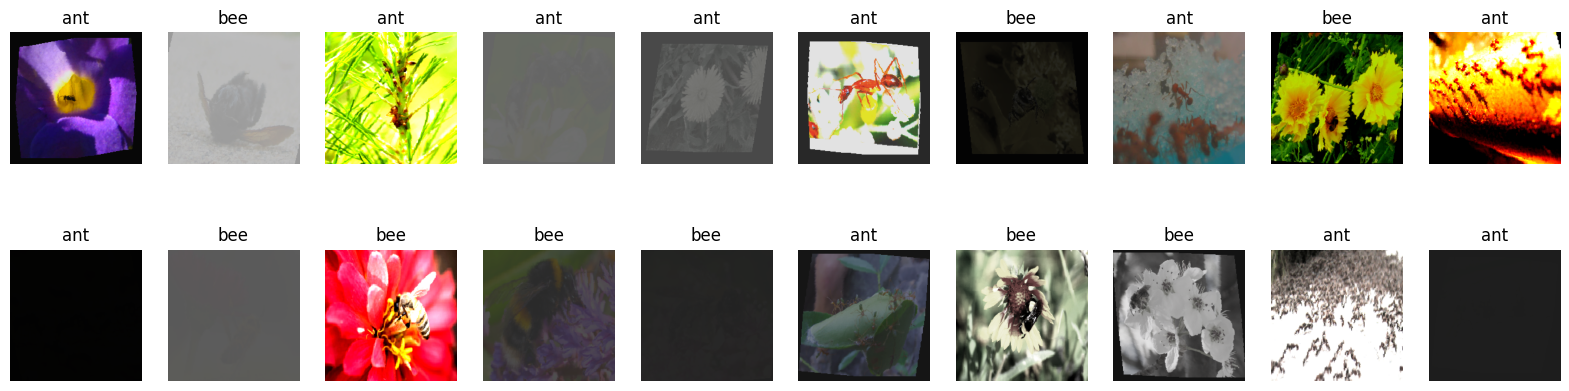

In [27]:
figure = plt.figure(figsize = (20,8))    

for i in range(batch_size):
    axes = figure.add_subplot(3, 10, i+1)
    image = convert_img(train_images[i])
    title = classes[train_labels[i]]
    plt.imshow(image) 
    plt.title(title)
    plt.axis('off')

plt.show()

In [28]:
alexNet_model = models.alexnet(pretrained=True)
print(alexNet_model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [29]:
for feature_extraction_layer in alexNet_model.features.parameters():
    feature_extraction_layer.requires_grad = False

last_layer_inputs = alexNet_model.classifier[6].in_features
last_layer = nn.Linear(last_layer_inputs, len(classes))
alexNet_model.classifier[6] = last_layer
alexNet_model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [30]:
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(alexNet_model.parameters(), lr = 0.0001)

In [31]:
numEpochs = 10
train_count = len(train_loader) * batch_size
test_count = len(test_loader)  * batch_size
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# training with the number of epochs.
for epoch in range(numEpochs):
    train_loss = 0.0
    test_loss = 0.0
    train_acc = 0.0
    test_acc = 0.0
  
    # training the model with the train dataset.
    for train_images, train_labels in train_loader:
    
        # register train images and labels to device
        train_images = train_images.to(device)
        train_labels = train_labels.to(device)
    
        # calculate loss for training dataset for current batch
        train_labels_head = alexNet_model.forward(train_images)
        loss = criterion(train_labels_head, train_labels)
    
        # updating weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
    
        # calculate accuracy for the current batch for training dataset
        predictions = torch.max(train_labels_head, 1)[1] 
        accuracy = torch.sum(predictions == train_labels)
    
        # sum training acurracy and loss with remaining batches
        train_acc += accuracy 
        train_loss += loss.item()
    
    print("EPOCH --> " + str(epoch + 1))
    print("----------------------------------------------")
  
    # test the current model within current epoch
    for test_images, test_labels in test_loader:
    
        # register test images and labels to device to benefit from GPU
        test_images = test_images.to( device )
        test_labels = test_labels.to( device )
    
        # calculate loss for test dataset for current batch
        test_labels_head = alexNet_model.forward(test_images)
        loss = criterion(test_labels_head, test_labels)
    
        # calculate acurracy for the current batch for test dataset
        predictions = torch.max( test_labels_head , 1)[1] 
        accuracy = torch.sum(predictions == test_labels)
    
        # summing test acurracy and 
        # loss wit the remaining batches.
        test_acc += accuracy 
        test_loss += loss.item()
 
    # printing out the training dataset results for current batch
    train_acc = float(train_acc.float()) / train_count
    train_accuracies.append(train_acc)
    print("Train Accuracy: " + str(float(train_acc)))
    
    train_loss = train_loss / train_count
    train_losses.append(train_loss)
    print("Train Loss: " + str(train_loss) + "\n")
  
    # printing out the test dataset 
    # results for the current batch.
    test_acc = float(test_acc.float()) / test_count
    test_accuracies.append( test_acc )
    print("Test Accuracy: " + str(float(test_acc)))    
    
    test_loss = test_loss / test_count
    test_losses.append(test_loss)
    print("Test Loss: " + str(test_loss))
    print("----------------------------------------------\n")

EPOCH --> 1
----------------------------------------------
Train Accuracy: 0.5692307692307692
Train Loss: 0.03381850123405457

Test Accuracy: 0.73125
Test Loss: 0.023746381420642136
----------------------------------------------

EPOCH --> 2
----------------------------------------------
Train Accuracy: 0.6961538461538461
Train Loss: 0.027134814399939318

Test Accuracy: 0.80625
Test Loss: 0.020276544522494076
----------------------------------------------

EPOCH --> 3
----------------------------------------------
Train Accuracy: 0.6923076923076923
Train Loss: 0.022883804543660236

Test Accuracy: 0.83125
Test Loss: 0.019120876397937536
----------------------------------------------

EPOCH --> 4
----------------------------------------------
Train Accuracy: 0.7153846153846154
Train Loss: 0.0212245836853981

Test Accuracy: 0.8125
Test Loss: 0.0178582108579576
----------------------------------------------

EPOCH --> 5
----------------------------------------------
Train Accuracy: 0.75384

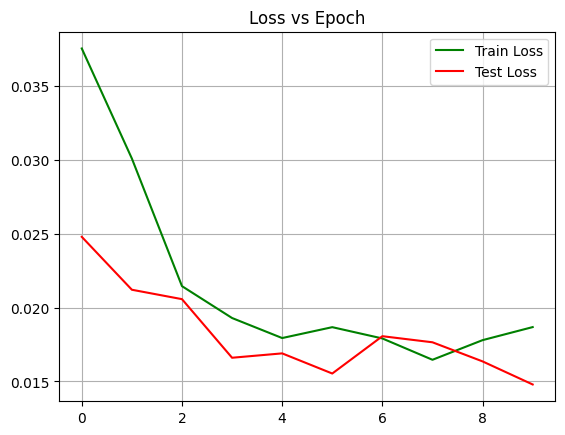

In [12]:
# plot loss graph
plt.title("Loss vs Epoch")
plt.plot(train_losses, label = "Train Loss", color= "green")
plt.plot(test_losses, label = "Test Loss", color= "red")
plt.legend()
plt.grid()

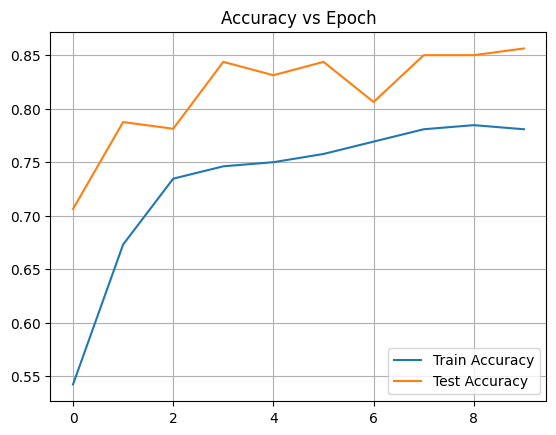

In [13]:
plt.title("Accuracy vs Epoch")
plt.plot(train_accuracies, label = "Train Accuracy")
plt.plot(test_accuracies, label = "Test Accuracy")
plt.legend()
plt.grid()

In [14]:
test_iterator = iter(test_loader)
test_images, test_labels = next(test_iterator)
test_labels = test_labels.to(device)
test_images = test_images.to(device)
test_predict = alexNet_model.forward(test_images)
test_predict = torch.max(test_predict, 1)[1] 
print(test_images.shape)
print(test_labels.shape)
print(test_predict.shape)

torch.Size([20, 3, 224, 224])
torch.Size([20])
torch.Size([20])


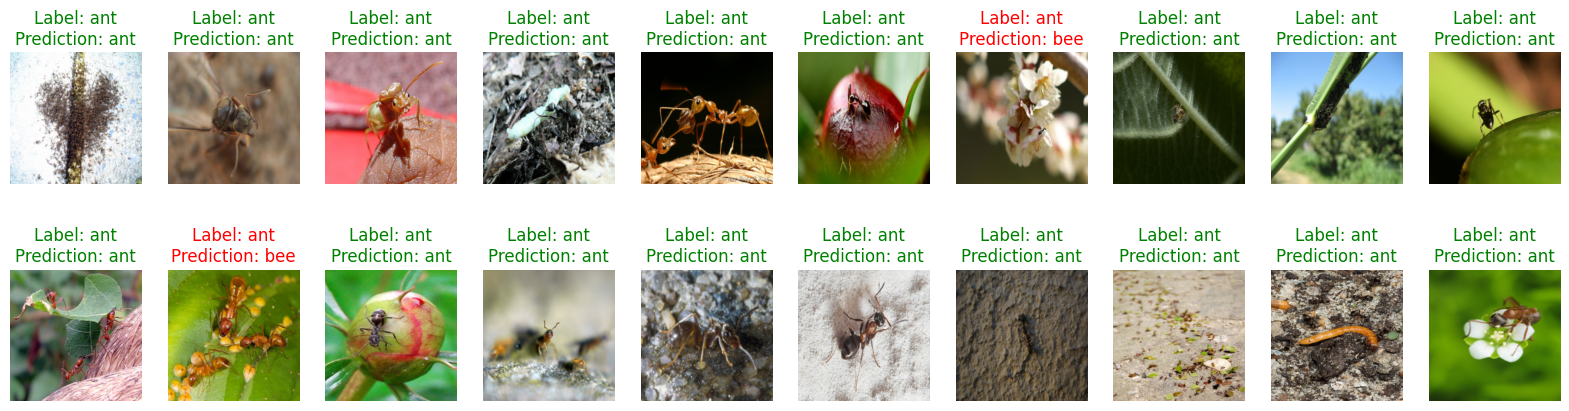

In [15]:
figure = plt.figure(figsize=(20,8))    

for i in range(batch_size):
    axes = figure.add_subplot(3, 10, i+1)
    image = convert_img_cuda(test_images[i])
    title = "Label: " + str(classes[test_labels[i]]) + "\n" + "Prediction: " + str(classes[test_predict[i]]) 
    plt.imshow(image) 
    plt.axis('off')
    if(str(classes[test_labels[i]]) == str(classes[test_predict[i]])):
        plt.title(title, color="green")
    else:
        plt.title(title, color="red")

plt.show()

In [16]:
accuracy = torch.sum(test_predict == test_labels)
print("Test Accuracy:", float(accuracy) / batch_size)

Test Accuracy: 0.9
